In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import interp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.ensemble import GradientBoostingClassifier as gboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (precision_recall_curve, average_precision_score, 
                             roc_curve, auc, confusion_matrix, mean_squared_error,
                             classification_report)
from sklearn import metrics
from sklearn.model_selection import cross_validate
import tensorflow

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, Lambda
from keras.layers import Activation
from keras.optimizers import RMSprop
from keras.layers import Merge
from keras import backend as K
from functools import partial

Using TensorFlow backend.


In [2]:
NB_EPOCH = 2000
BATCH_SIZE = 64 

def printdf(dfa):
    """ print the unique values of the dataframe """
    lbla = dfa.columns
    for n in range(len(lbla)):
        print(lbla[n], np.unique(dfa[lbla[n]]))
#
# Last card of function printdf.
#
def convertstringtonumber(dfa, lst):
    """ convert string to number """
    for n in range(len(lst)):
        dfa = dfa.replace(lst[n], n)
    return dfa
#
# Last card of convertstringtonumber.
#
def scalex(X):
    """ normalize between 0 and 1 the values in X """
    nmin, nmax = 0.0, 1.0
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (nmax - nmin) + nmin
    return X_scaled
#
# Last card of scalex.
#
def calcrmse(X_train, gensamples):
    """ compute mse for training """
    max_column = X_train.shape[1]
    rmse_lst = []
    for col in range(max_column):
        rmse_lst.append(np.sqrt(mean_squared_error(X_train[:,col], gensamples[:,col])))
    return np.sum(rmse_lst) / max_column
#
# Last card of calcrmse.
#
def plotoriginalsamples(X_train, dimCol=[0,1]):
    """ plot 2d samples for quick visual check """
    if len(dimCol) > 2: raise ValueError("Only 2 dim. list allowed for dimCol.")
    pl.figure(figsize=(10,10))
    pl.scatter(X_train[:,dimCol[0]], X_train[:,dimCol[1]], s = 40, alpha=0.2, 
               edgecolor = 'k', marker = '+',label='original samples') 
    pl.xticks([], [])
    pl.yticks([], [])
    pl.legend(loc='best')
    pl.tight_layout()
    pl.show()
#
# Last card of plotoriginalsamples.
#
def wasserstein_loss(y_true, y_pred):
    """ Wasserstein distance """
    return K.mean(y_true * y_pred)
#
# Last card of wasserstein_loss.
#
def gradient_penalty_loss(y_true, y_pred, averaged_samples, lamba_reg):
    """ compute gradient penalty loss for GP-WGAN """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = lamba_reg * K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)
#
# Last card of gradient_penalty_loss.
#
class RandomWeightedAverage(Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])
#
# Last card of RandomWeightedAverage.
#
def generate_samples(generator_model, noise_dim, num_samples):
    """ generate samples to be used for futher analysis """
    return generator_model.predict(np.random.rand(num_samples, noise_dim))
#
# Last card of generate_samples.
#
def generate_images2D(generator_model, X_train, noise_dim, num_samples=1000):
    """ generator and plot 2d figures for visual check of the GAN's training """
    predicted_samples = generator_model.predict(np.random.rand(num_samples, noise_dim))
    #
    pl.figure(figsize=(10,10))
    pl.scatter(X_train[:,2], X_train[:,22], s = 40, alpha=0.2, edgecolor = 'k', 
               marker = '+',label='original samples') 
    pl.scatter(predicted_samples[:,0], predicted_samples[:,1],s = 10, alpha=0.9,
               c='r', edgecolor = 'k', marker = 'o',label='predicted') 
    pl.xticks([], [])
    pl.yticks([], [])
    pl.legend(loc='best')
    pl.tight_layout()    
    pl.show()
    return predicted_samples
#
# Last card of generate_images2D.
#
def writetocsv(mtrx, flnm):
    """Save the samples for TDA with R (2nd notebook). We do not differentiate frauds from normal transactions"""
    dtfrm = pd.DataFrame(mtrx)
    dtfrm.to_csv(flnm, sep=',', index=None, header=None)
#
# Last card of writetocsv.
#
# In[1]:
df = pd.read_csv('./data/KDDTrain+.txt', sep=",", header=None)
print(df)


        0    1         2   3     4     5   6   7   8   9   ...    33    34  \
0        0  tcp  ftp_data  SF   491     0   0   0   0   0  ...  0.17  0.03   
1        0  udp     other  SF   146     0   0   0   0   0  ...  0.00  0.60   
2        0  tcp   private  S0     0     0   0   0   0   0  ...  0.10  0.05   
3        0  tcp      http  SF   232  8153   0   0   0   0  ...  1.00  0.00   
4        0  tcp      http  SF   199   420   0   0   0   0  ...  1.00  0.00   
...     ..  ...       ...  ..   ...   ...  ..  ..  ..  ..  ...   ...   ...   
125968   0  tcp   private  S0     0     0   0   0   0   0  ...  0.10  0.06   
125969   8  udp   private  SF   105   145   0   0   0   0  ...  0.96  0.01   
125970   0  tcp      smtp  SF  2231   384   0   0   0   0  ...  0.12  0.06   
125971   0  tcp    klogin  S0     0     0   0   0   0   0  ...  0.03  0.05   
125972   0  tcp  ftp_data  SF   151     0   0   0   0   0  ...  0.30  0.03   

          35    36    37    38    39    40       41  42  
0    

             41
0        normal
1        normal
2       neptune
3        normal
4        normal
...         ...
125968  neptune
125969   normal
125970   normal
125971  neptune
125972   normal

[125973 rows x 1 columns]
Protocole Type:
 ['icmp' 'tcp' 'udp']
Type Of Attacks:
 ['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop         

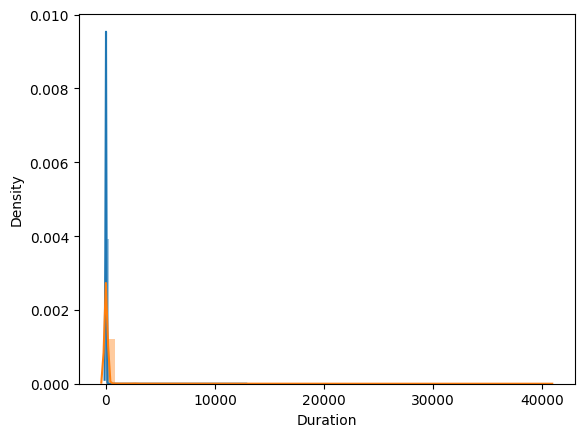

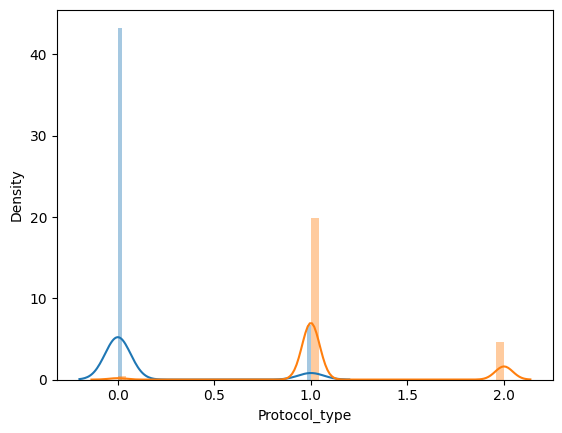

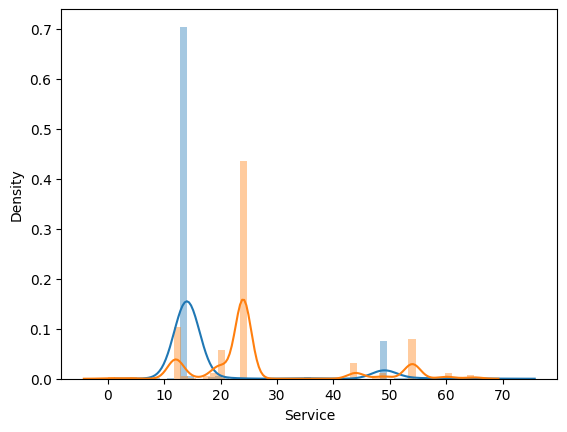

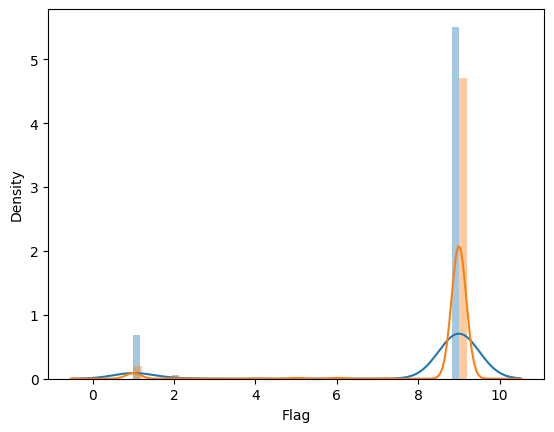

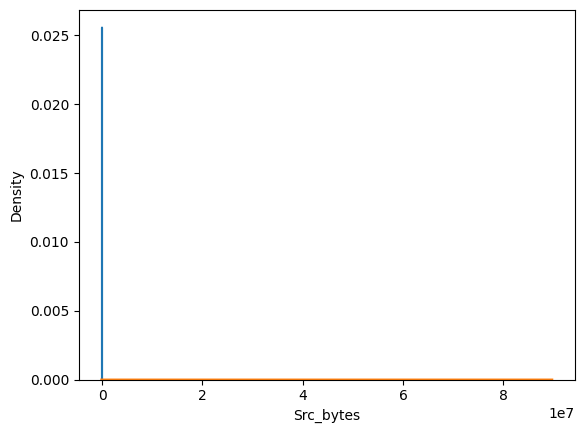

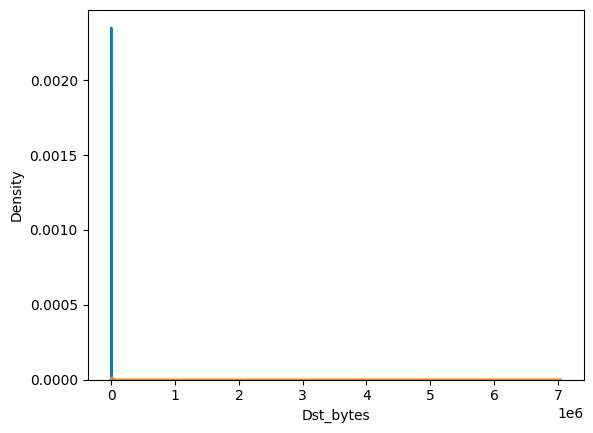

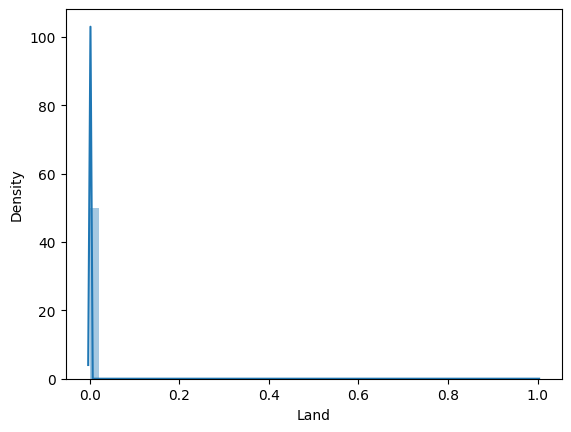

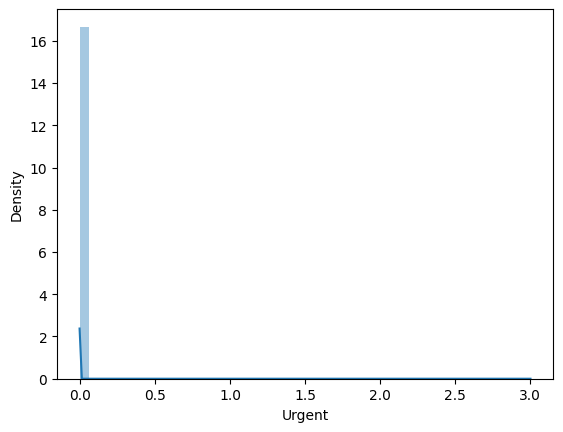

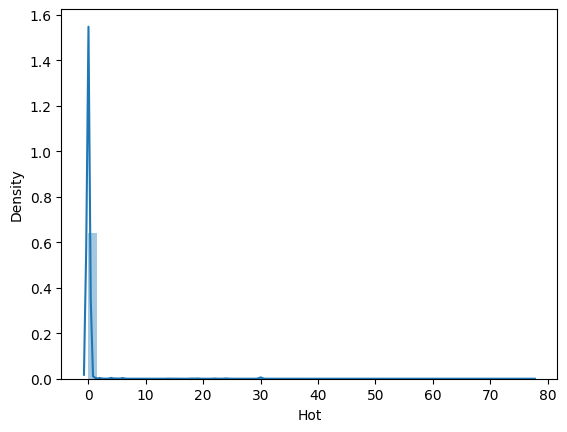

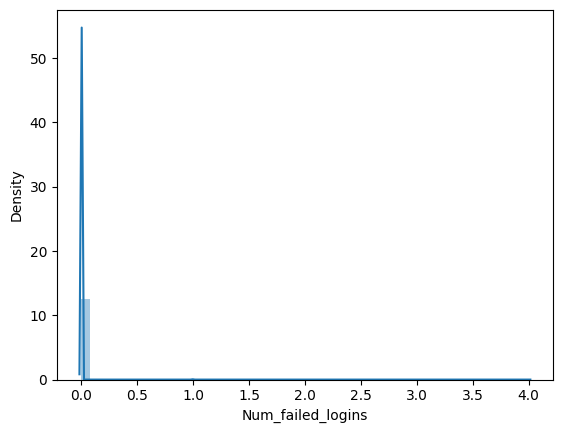

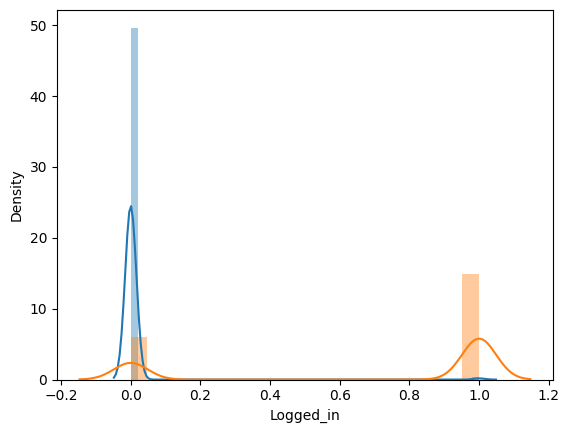

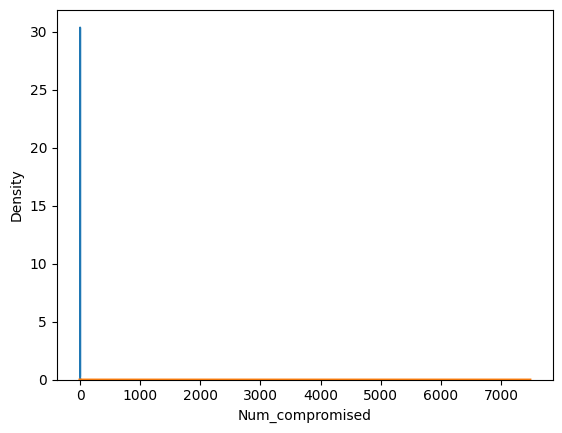

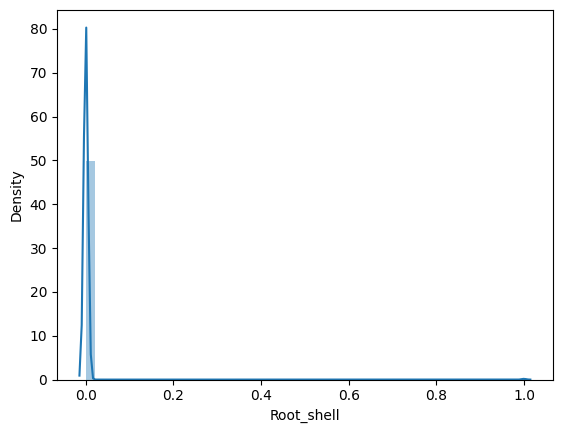

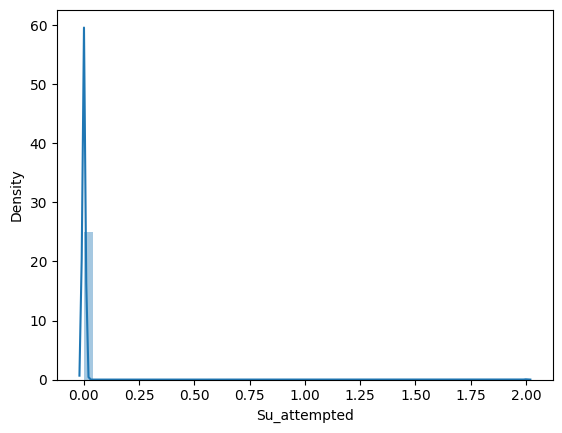

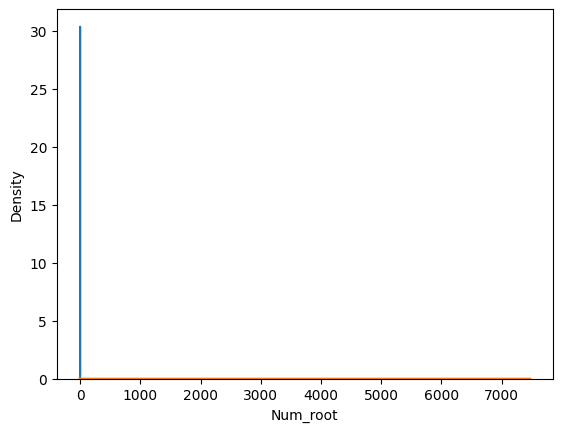

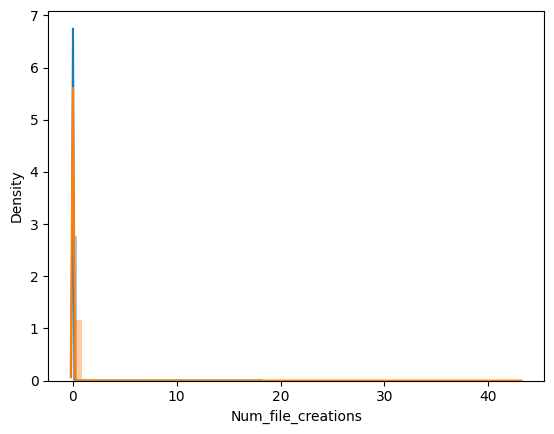

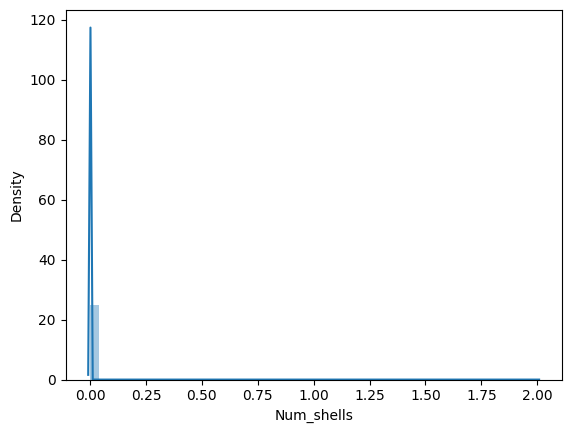

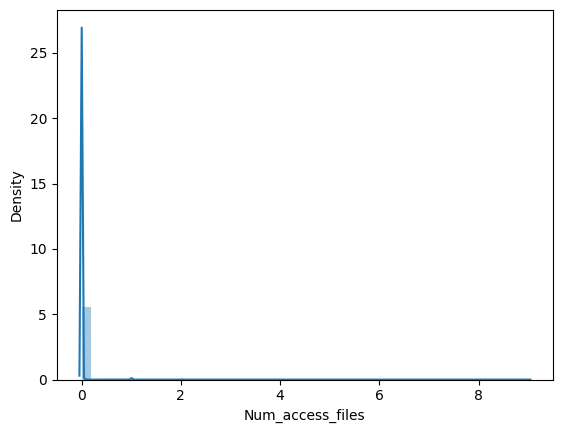

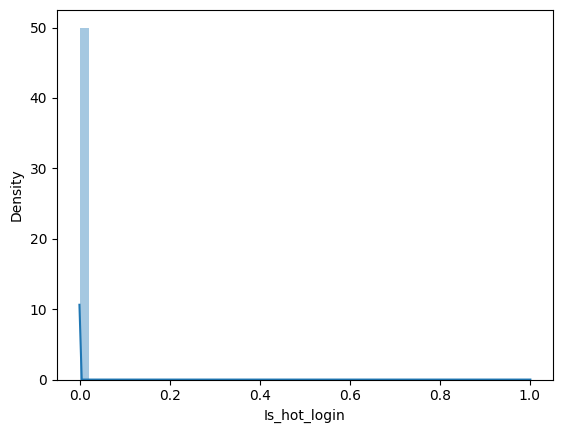

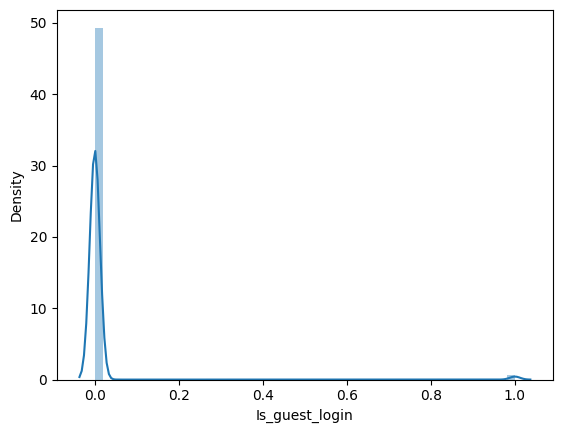

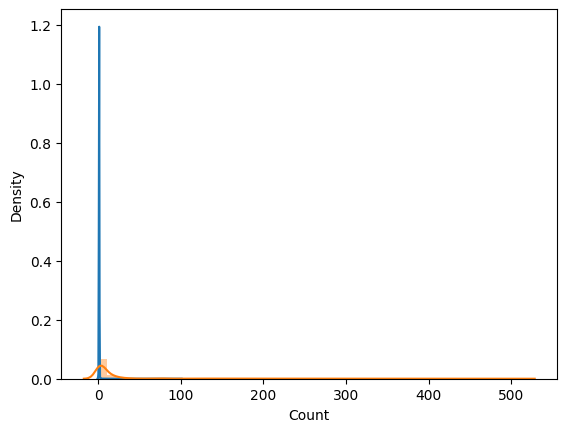

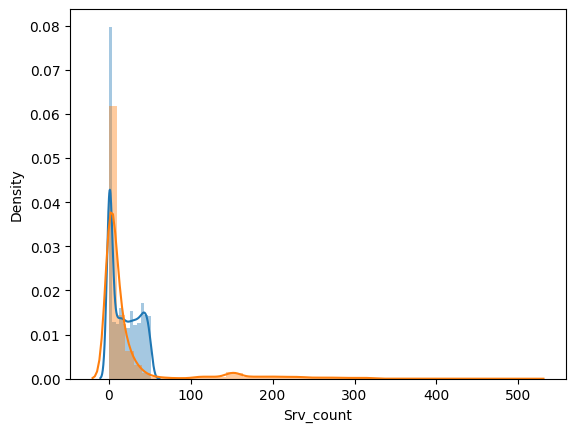

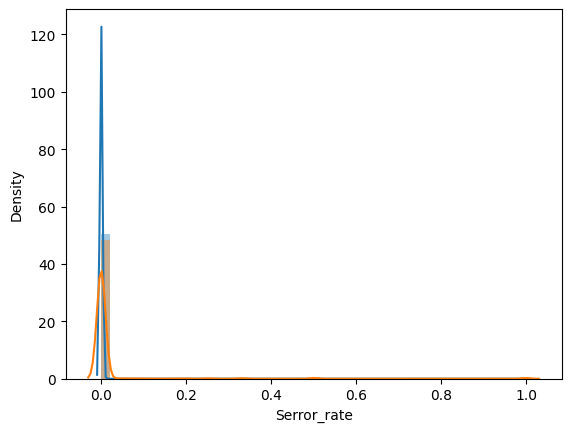

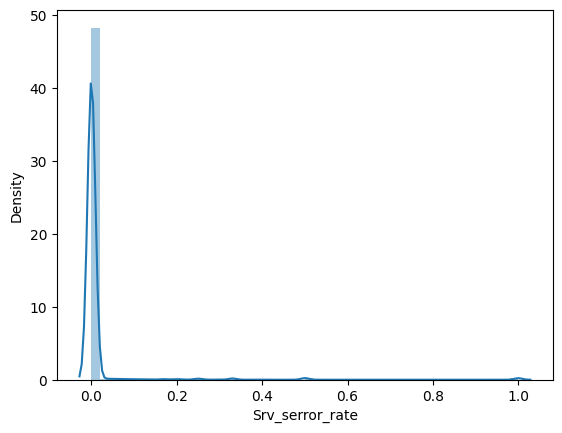

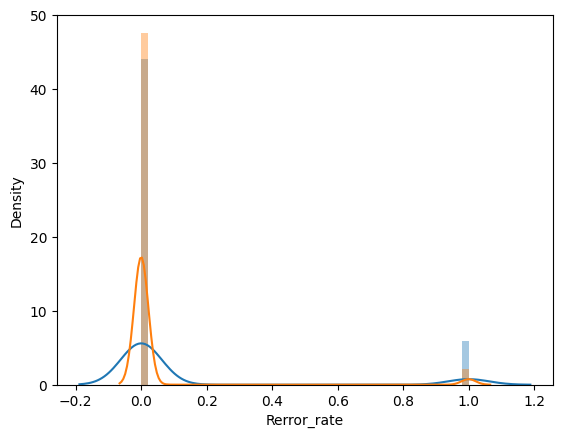

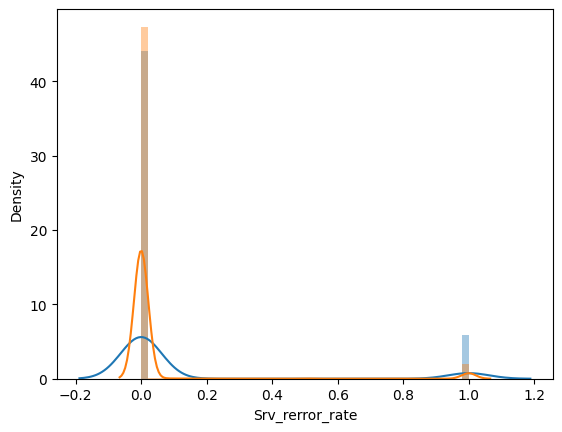

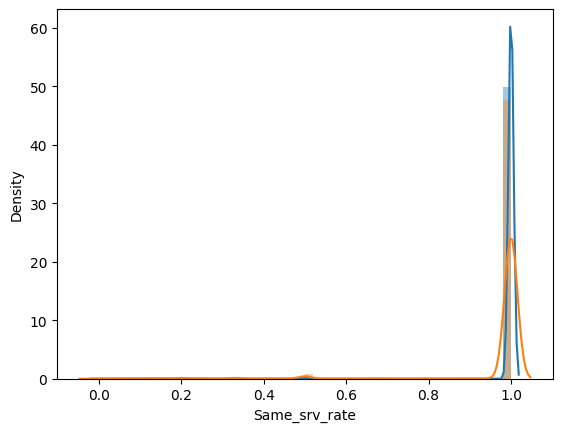

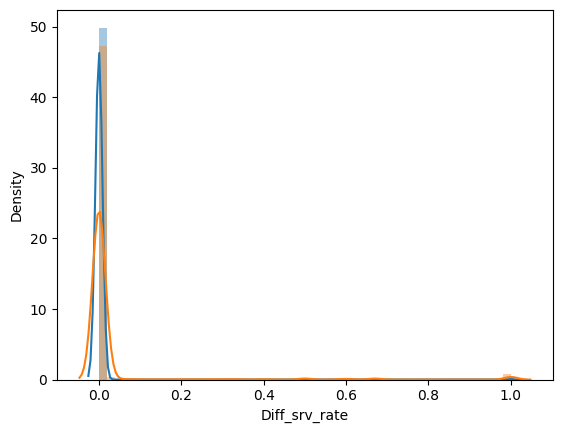

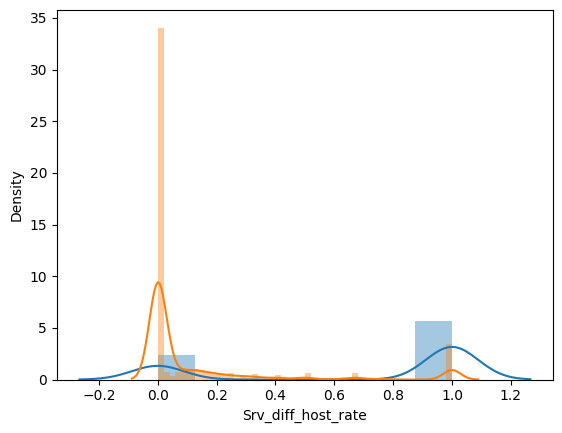

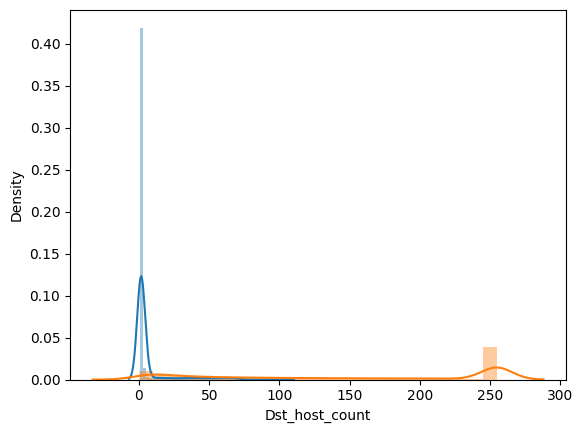

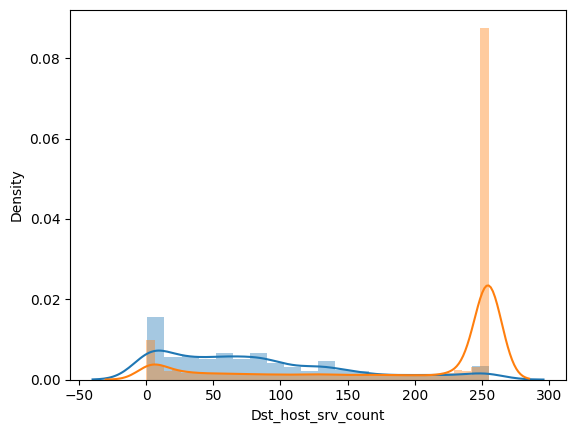

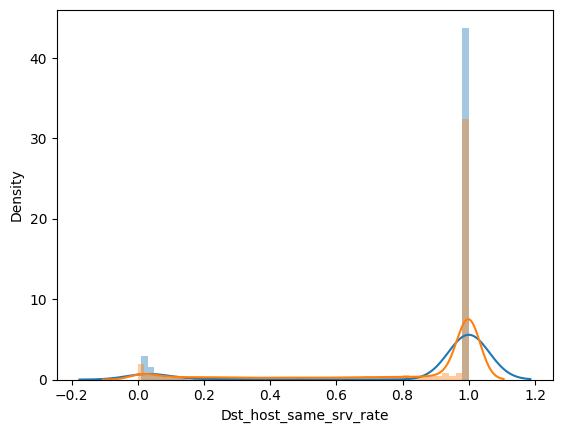

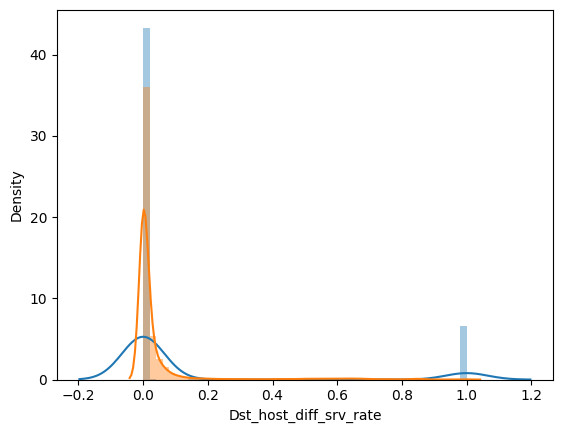

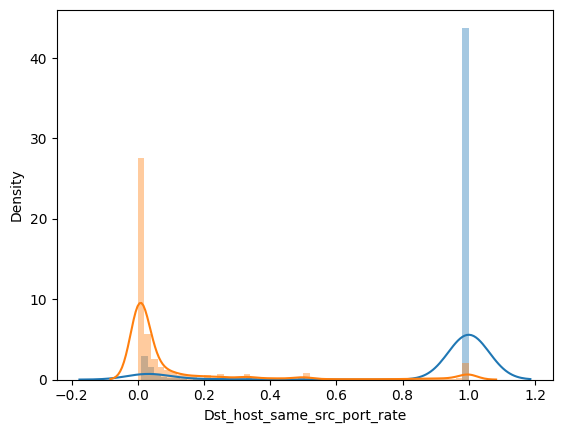

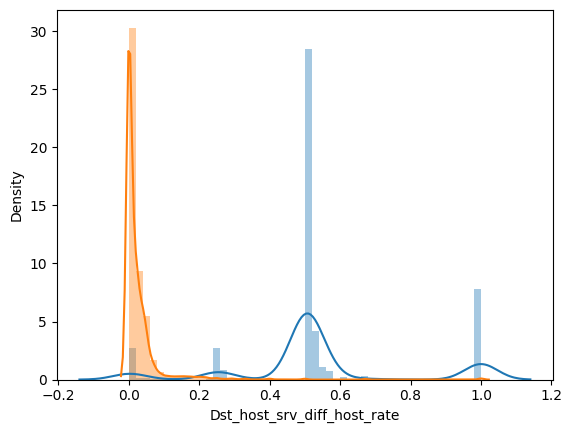

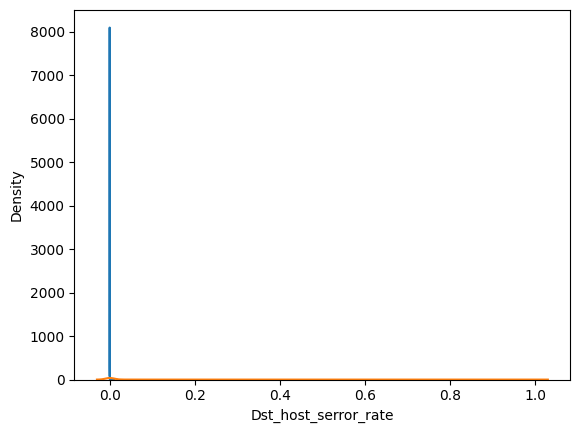

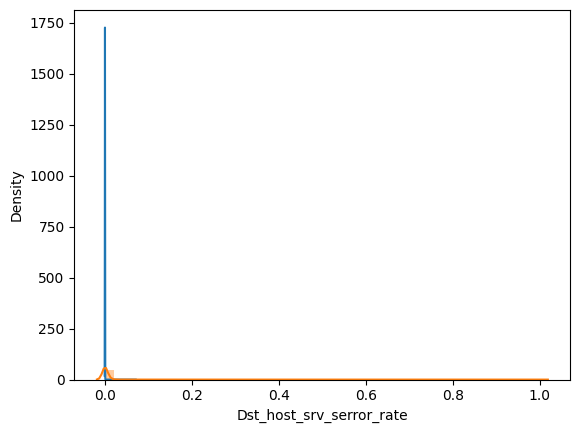

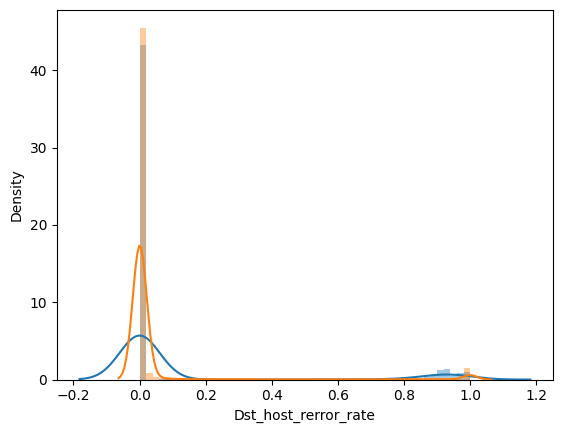

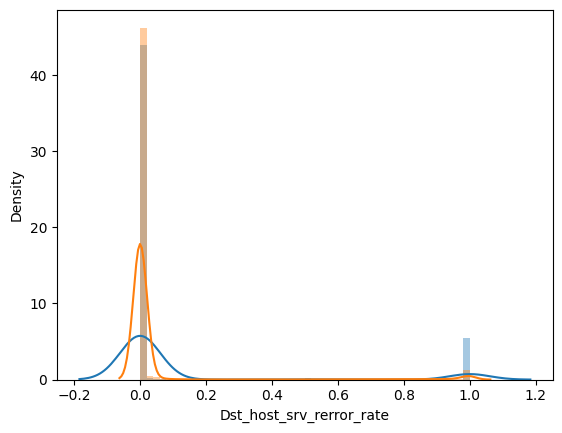

In [3]:
print(df.iloc[:, [41]])
print("Protocole Type:\n", np.unique(df.iloc[:, [1]]))
print("Type Of Attacks:\n", np.unique(df.iloc[:, [41]]))

# define column names
lbl = ["Duration", "Protocol_type", "Service", "Flag", "Src_bytes", "Dst_bytes", 
       "Land", "Wrong_fragment", "Urgent", "Hot", "Num_failed_logins", "Logged_in", 
       "Num_compromised", "Root_shell", "Su_attempted", "Num_root", "Num_file_creations",
       "Num_shells", "Num_access_files", "Num_outbound_cmds", "Is_hot_login", 
       "Is_guest_login", "Count", "Srv_count", "Serror_rate", "Srv_serror_rate",
       "Rerror_rate", "Srv_rerror_rate", "Same_srv_rate", "Diff_srv_rate",
       "Srv_diff_host_rate", "Dst_host_count", "Dst_host_srv_count", "Dst_host_same_srv_rate", 
       "Dst_host_diff_srv_rate", "Dst_host_same_src_port_rate", "Dst_host_srv_diff_host_rate",
       "Dst_host_serror_rate", "Dst_host_srv_serror_rate", "Dst_host_rerror_rate",
       "Dst_host_srv_rerror_rate", "attack_type", "Class"]

desc_lbl = {"Duration": "Length of time duration of the connection", 
            "Protocol_type": "Protocol used in the connection", 
            "Service": "Destination network service used",
            "Flag": "Status of the connection - Normal or Error", 
            "Src_bytes": "Number of data bytes transferred from source to destination in single connection", 
            "Dst_bytes": "Number of data bytes transferred from destination to source in single connection", 
            "Land": "If source and destination IP addresses and port numbers are equal then, this variable takes value 1 else 0", 
            "Wrong_fragment": "Total number of wrong fragments in this connection", 
            "Urgent": "Number of urgent packets in this connection. Urgent packets are packets with the urgent bit activated", 
            "Hot": "Number of hot indicators in the content such as entering a system directory, creating programs and executing programs", 
            "Num_failed_logins": "Count of failed login attempts", 
            "Logged_in": "Login Status : 1 if successfully logged in; 0 otherwise", 
            "Num_compromised": "Number of compromised conditions", 
            "Root_shell": "1 if root shell is obtained; 0 otherwise", 
            "Su_attempted": "1 if su root command attempted or used; 0 otherwise", 
            "Num_root": "Number of root accesses or number of operations performed as a root in the connection", 
            "Num_file_creations": "Number of file creation operations in the connection",
            "Num_shells": "Number of shell prompts", 
            "Num_access_files": "Number of operations on access control files", 
            "Num_outbound_cmds": "Number of outbound commands in an ftp session", 
            "Is_hot_login": "1 if the login belongs to the hot list i.e., root or admin; else 0",
            "Is_guest_login": "1 if the login is a guest login; 0 otherwise", 
            "Count": "Number of connections to the same destination host as the current connection in the past two seconds", 
            "Srv_count": "Number of connections to the same service (port number) as the current connection in the past two seconds", 
            "Serror_rate": "The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in count", 
            "Srv_serror_rate": "The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in srv_count",
            "Rerror_rate": "The percentage of connections that have activated the flag (4) REJ, among the connections aggregated in count", 
            "Srv_rerror_rate": "The percentage of connections that have activated the flag (4) REJ, among the connections aggregated in srv_count", 
            "Same_srv_rate": "The percentage of connections that were to the same service, among the connections aggregated in count", 
            "Diff_srv_rate": "The percentage of connections that were to different services, among the connections aggregated in count",
            "Srv_diff_host_rate": "The percentage of connections that were to different destination machines among the connections aggregated in srv_count", 
            "Dst_host_count": "Number of connections having the same destination host IP address", 
            "Dst_host_srv_count": "Number of connections having the same port number", 
            "Dst_host_same_srv_rate": "The percentage of connections that were to the same service, among the connections aggregated in dst_host_count",
            "Dst_host_diff_srv_rate": "The percentage of connections that were to different services, among the connections aggregated in dst_host_count ", 
            "Dst_host_same_src_port_rate": "The percentage of connections that were to the same source port, among the connections aggregated in dst_host_srv_c ount", 
            "Dst_host_srv_diff_host_rate": "The percentage of connections that were to different destination machines, among the connections aggregated in dst_host_srv_count", 
            "Dst_host_serror_rate": "The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in dst_host_count", 
            "Dst_host_srv_serror_rate": "The percent of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in dst_host_srv_c ount", 
            "Dst_host_rerror_rate": "The percentage of connections that have activated the flag (4) REJ , among the connections aggregated in dst_host_count", 
            "Dst_host_srv_rerror_rate": "The percentage of connections that have activated the flag (4) REJ, among the connections aggregated in dst_host_srv_count"}

df.columns = lbl

dos_attacks = ["back", "land", "neptune", "pod", "smurf", "teardrop", "apache2",
               "udpstorm", "processtable", "worm"]
probe_attacks = ["Satan", "Ipsweep", "Nmap", "Portsweep", "Mscan", "Saint"]
r2l_attacks = ["guess_Password", "ftp_write", "imap", "phf", "multihop", "warezmaster", 
               "warezclient", "spy", "xlock", "xsnoop", "snmpguess", "snmpgetattack", 
               "httptunnel", "sendmail", "named"]
u2l_attacks = ["buffer_overflow", "loadmodule", "rootkit", "perl", "sqlattack", 
               "xterm", "ps"]



# convert strings to numbers
protocol_type = ['icmp', 'tcp', 'udp']
service = ['IRC','X11','Z39_50','aol','auth','bgp','courier','csnet_ns','ctf',
           'daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs',
           'exec','finger','ftp','ftp_data','gopher','harvest','hostnames','http',
           'http_2784','http_443','http_8001','imap4','iso_tsap','klogin','kshell',
           'ldap','link','login','mtp','name','netbios_dgm','netbios_ns',
           'netbios_ssn','netstat','nnsp','nntp','ntp_u','other','pm_dump','pop_2',
           'pop_3','printer','private','red_i','remote_job','rje','shell','smtp',
           'sql_net','ssh','sunrpc','supdup','systat','telnet','tftp_u','tim_i',
           'time','urh_i','urp_i','uucp','uucp_path','vmnet','whois']
flag = ['OTH','REJ','RSTO','RSTOS0','RSTR','S0','S1','S2','S3','SF','SH']

attack_counts = df['attack_type'].value_counts()

# Print the counts
print(attack_counts)

df = convertstringtonumber(df, protocol_type)
df = convertstringtonumber(df, service)
df = convertstringtonumber(df, flag)

# observe the conversion
for n in range(len(lbl)):
    print(lbl[n], np.unique(df[lbl[n]]))

# In[3]: target the attacks generation

def create_normalized_dataframe(df, attack_name):
    df_new = df.loc[df["attack_type"] == attack_name]

    df_new = df_new.drop(columns=["Class"])
    features = []
    for n in range(len(lbl)-2):
        m = lbl[n]
        tmp = np.unique(df_new[m])
        print(m, tmp)
        if (len(tmp) > 1):
            features.append(m)
            plt.figure(n)
            sns.distplot(df_new[m])
    
    # normalize each field independently
    df_attack_norm = df_new
    for n in range(len(lbl)-2):
        m = lbl[n]
        if (np.max(df_attack_norm[m]) > 1): 
            if (len(np.unique(df_attack_norm[m])) > 1):
                df_attack_norm[m] = scalex(df_attack_norm[m])
            else:
                df_attack_norm[m] = np.int64(1)
    printdf(df_attack_norm)  
    
    for n in range(len(lbl)-1):
        print(lbl[n], np.unique(df_attack_norm[lbl[n]]))
    return df_new
    
attack_name = "ipsweep"
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_normal_norm = create_normalized_dataframe(df, "normal")

In [4]:
# In[3]: build GP-WGAN and generate adversarial samples
#
GRADIENT_PENALTY_WEIGHT = 0.01 #0.1


if attack_name == "smurf":
    MAX_SIM = 2500 #10000
    #
    MAX_EPOCH = 2000 #15000
    TRAINING_RATIO = 5
    NUM_SAMPLES = 2500 #5000
elif attack_name == "ipsweep":
    MAX_SIM = 3500
    MAX_EPOCH = 2000 #15000
    TRAINING_RATIO = 5
    NUM_SAMPLES = 3500 #5000
    


X_train = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])
np.random.shuffle(X_train)

#
### Building the model
def make_generator(noise_dim=100):
    model = Sequential()
    model.add(Dense(128,  kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(64,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(64,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(64,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=noise_dim, activation='linear'))
    return model
#
#    Last card of make_generator.
#    
def make_discriminator():
    model = Sequential()
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(64, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=1, activation='linear'))
    return model
#
#    Last card of make_discriminator.
#
print("current_gradpenalty:", GRADIENT_PENALTY_WEIGHT)

#In summary, this code sets up the parameters and defines the architecture for a GP-WGAN.
#It prepares the training data, defines the generator and discriminator models, and prints the gradient penalty weight.
#The actual training of the GAN is not included in this code.

current_gradpenalty: 0.01


In [5]:
INPUT_DIM = X_train.shape[1]
noise_dim = INPUT_DIM

generator = make_generator(noise_dim)
discriminator = make_discriminator()


#### for the generator it is mostly the same as WGAN std
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

generator_input = Input(shape=(noise_dim,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)

generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
generator_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss=wasserstein_loss)


#### New discriminator model for GPWGAN
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False 


real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(noise_dim,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator], 
                            outputs=[discriminator_output_from_real_samples, discriminator_output_from_generator, 
                                     averaged_samples_out])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_samples, lamba_reg=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gp_loss' 


# finally, we compile the model
discriminator_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), 
                            loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss])


### Running the Full Model
#def discriminator_clip(f,c):
 #   for l in f.layers:
   #     weights = l.get_weights()
    #    weights = [np.clip(w, -c, c) for w in weights]
     #   l.set_weights(weights)


positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32) # dummy vector mandatory for the train on batch function

for epoch in range(MAX_EPOCH + 1):
    np.random.shuffle(X_train)

    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            sample_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            noise = np.random.rand(BATCH_SIZE, noise_dim).astype(np.float32)

            discriminator_model.train_on_batch([sample_batch, noise], [positive_y, negative_y, dummy_y])

        generator_model.train_on_batch(np.random.rand(BATCH_SIZE, noise_dim), positive_y)

    if (epoch % 500 == 0):
        gensamples = generate_samples(generator, noise_dim, MAX_SIM)
        rmse_sofar = calcrmse(X_train, gensamples)
        print("Epoch: ", epoch, "\t", "rmse: ", rmse_sofar)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Epoch:  0 	 rmse:  0.24213133257761651
Epoch:  500 	 rmse:  0.17240235128338965
Epoch:  1000 	 rmse:  0.15947028589203827
Epoch:  1500 	 rmse:  0.17297929816078497
Epoch:  2000 	 rmse:  0.15948978256148869


Visualizing Real Samples:


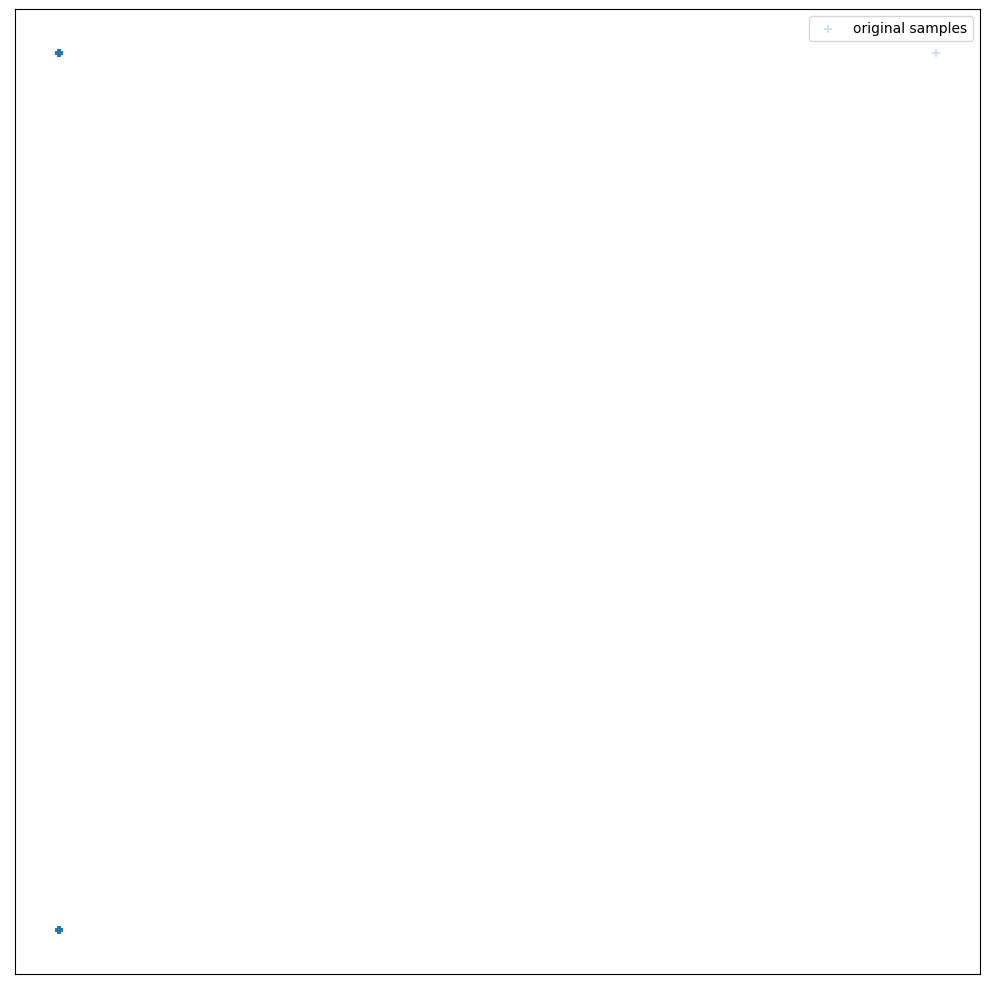

Visualizing Generated Samples:


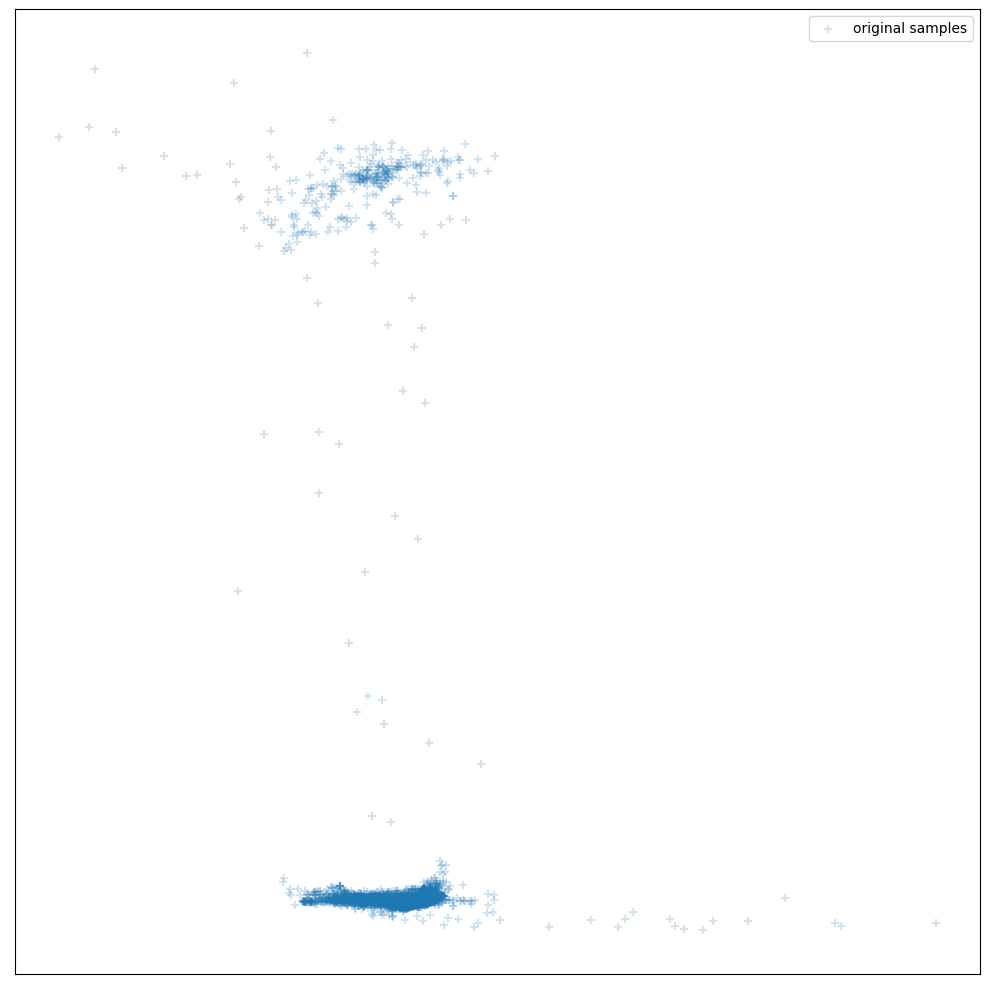

In [7]:
# assess visually the quality of the results
#generatorgpwgan = generator
#gensamples = generate_images3D(generatorgpwgan, noise_dim)
#plotoriginalsamples(X_train, dimCol=[2,22])
#gensamples = generate_images2D(generatorgpwgan, X_train, noise_dim)

#attack_name = "smurf"
#df_attack_norm = create_normalized_dataframe(df, attack_name)
#X_real = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])

# Generate samples using the trained generator model
#noise_dim = X_real.shape[1]
#num_generated_samples = 1000  # You can adjust this based on your preference
#generated_samples = generate_samples(generator, noise_dim, num_generated_samples)

# Visualize real and generated samples in a 2D plot
print("Visualizing Real Samples:")
plotoriginalsamples(X_train)

print("Visualizing Generated Samples:")
plotoriginalsamples(gensamples)

In [8]:
# results save
#writetocsv(X_train, "GPWGAN_original.csv")
#generated = generate_samples(generatorgpwgan, noise_dim, NUM_SAMPLES)
#print(calcrmse(X_train, generated))
#writetocsv(generated, "GPWGAN_generated.csv")

# convert generated array to dataframe
generated = pd.DataFrame(gensamples, columns=lbl[:-2])
generated["attack_type"] = pd.Series(["generated"]*len(generated), index = generated.index)


In [9]:
if attack_name == "smurf":
    list1 = [0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,26,27,28,30,31,36,37,38,39,40]
    list2 = [25,29,33,34,35]
    list3 = [22,32]
else:
    list1 = [0,1,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,26,27,35,36,37,38,39,40]
    list2 = [25,28,29,30,31,33,34]
    list3 = [2,22,32]

for n in range(41):#generated.columns:
    m = generated.columns[n]
    if n in list1:    
        generated[m] = np.round(generated[m], 0)
    elif n in list3:
        generated[m] = generated[m].clip(0.0, 1.0)
    elif n in list2:
        generated[m] = generated[m].clip(0.0, 1.0)
        generated[m] = np.round(generated[m], 2)
    if n == 3:
        generated[m] = generated[m].clip(0.0, 1.0)
        generated[m] = (generated[m] * 8 ).round(0) / 8
    if n == 23: 
        generated[m] = generated[m].clip(0.0, 1.0)
        generated[m] = (generated[m] * 48 ).round(0) / 48

In [10]:
indxi = 0
indxf = 10
for n in range(0,50,10):
    print()
    print("indxi:", indxi, "indxf:", indxf)
    print(df_attack_norm.iloc[:,indxi:indxf].head())
    print(generated.iloc[:,indxi:indxf].head())
    indxi += 10
    indxf += 10


indxi: 0 indxf: 10
     Duration  Protocol_type   Service  Flag  Src_bytes  Dst_bytes  Land  \
17        0.0              0  0.098361   1.0   0.004376        0.0     0   
30        0.0              0  0.098361   1.0   0.001945        0.0     0   
83        0.0              0  0.098361   1.0   0.001945        0.0     0   
158       0.0              0  0.098361   1.0   0.001945        0.0     0   
224       0.0              0  0.098361   1.0   0.001945        0.0     0   

     Wrong_fragment  Urgent  Hot  
17                0       0    0  
30                0       0    0  
83                0       0    0  
158               0       0    0  
224               0       0    0  
   Duration  Protocol_type   Service  Flag  Src_bytes  Dst_bytes  Land  \
0      -0.0           -0.0  0.098874   1.0        0.0       -0.0  -0.0   
1       0.0           -0.0  0.100634   1.0        0.0        0.0   0.0   
2       0.0           -0.0  0.087506   1.0        0.0        0.0   0.0   
3       0.0      

Visualizing Real Samples:


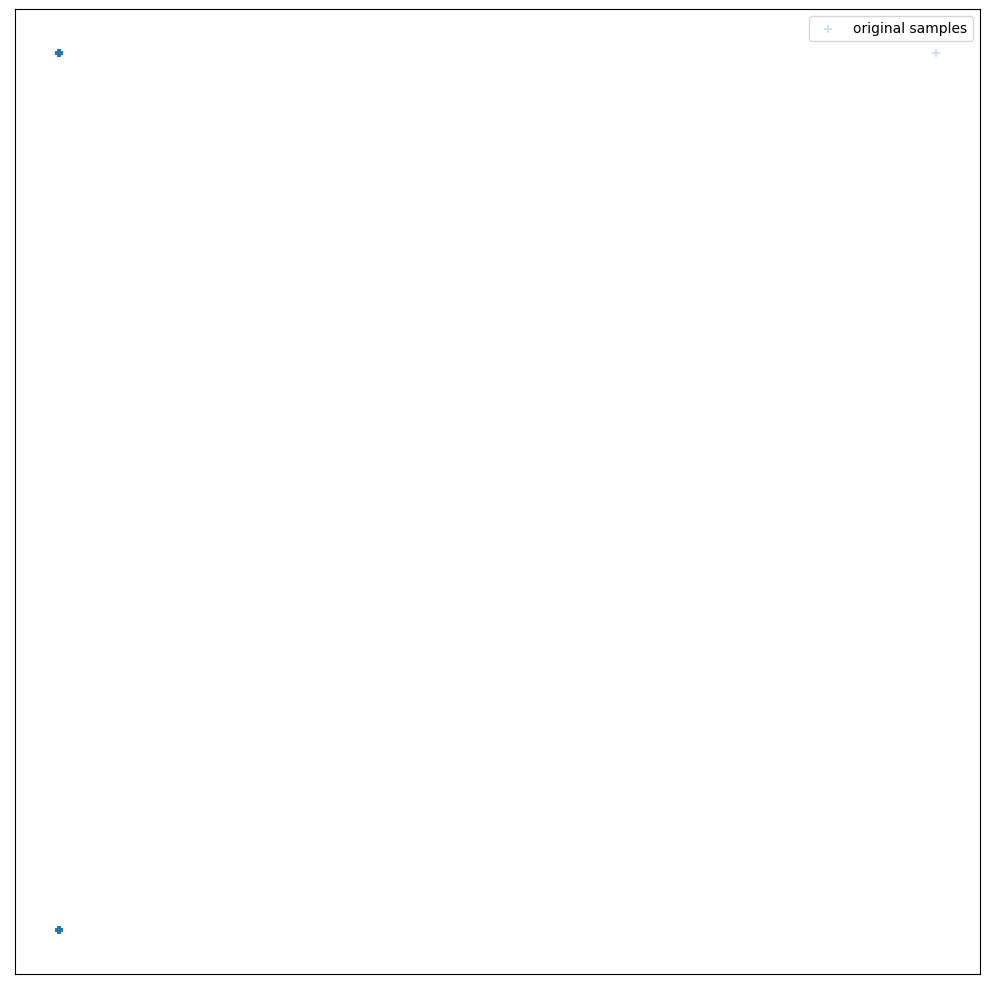

Visualizing Generated Samples:


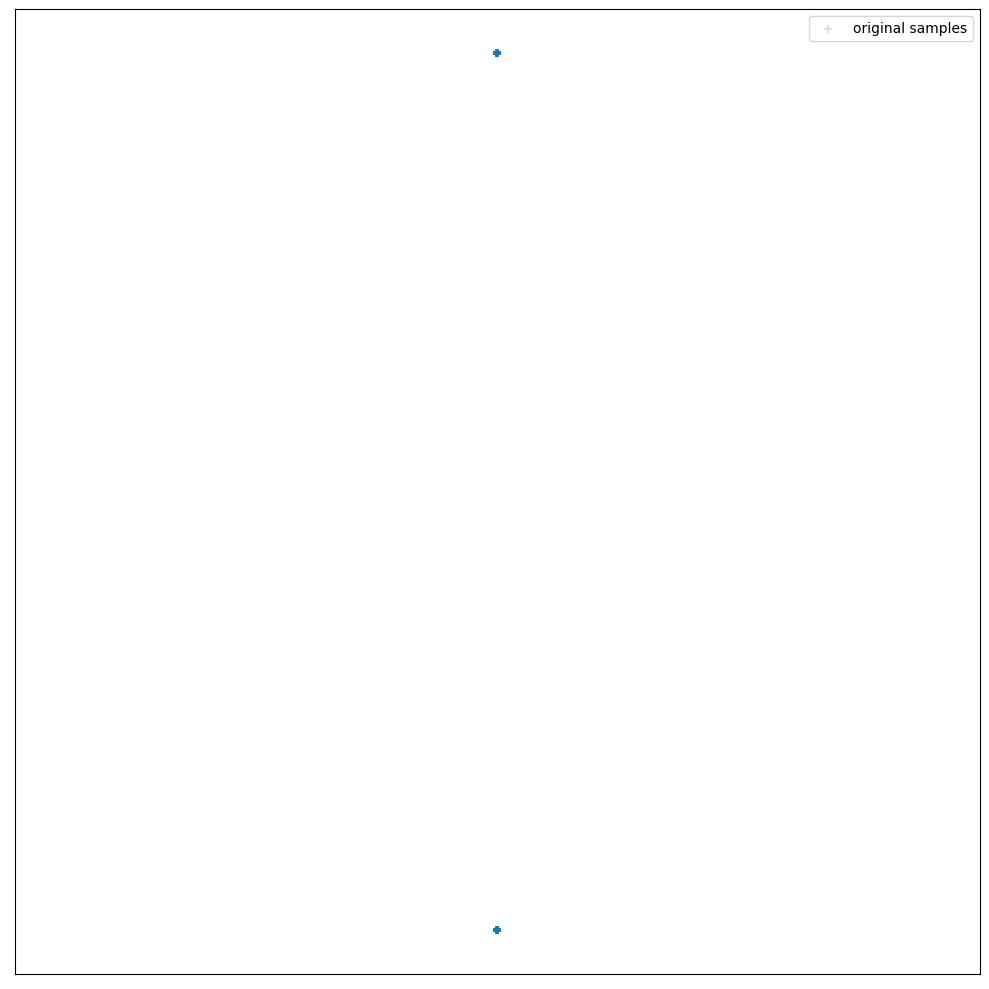

In [11]:
print("Visualizing Real Samples:")
plotoriginalsamples(X_train)

print("Visualizing Generated Samples:")
plotoriginalsamples(gensamples)

In [12]:
"""# In[2]:
# Classifier between malicious attacks and normal traffic
df_normal = df.loc[df["attack_type"] == "normal"]
#
# remove Dst_host_srv_count from the dataframe
df_normal = df_normal.drop(columns=['Dst_host_srv_count'])
#
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], y, 
                                                    test_size=.2, random_state=42)
# In[4]: 
# Prepare the data for the classification"""
bool_use_gendata = False
bool_use_normalIP = False

In [13]:
"""if bool_use_normalIP == True:
    generated = df_normal_norm
    generated = generated.replace("normal", "generated")    
    generated = generated.sample(frac=1)"""
    
# concatenate and shuffle generated and true data
if bool_use_gendata != True:
    #generated = df_attack_norm
    generated = generated.replace(attack_name, "generated")    
    generated = generated.sample(frac=1)

In [14]:
# aggregate generated data with true data
df_aggregated = pd.concat([df_attack_norm[:NUM_SAMPLES], generated[:NUM_SAMPLES]])
df_aggregated = df_aggregated.sample(frac=1)

In [15]:
# convert all numeric entries to float
#df_aggregated = df_aggregated.iloc[:,:41].astype(float)
df_aggregated = convertstringtonumber(df_aggregated, [attack_name, "generated"])

In [17]:
# remove Dst_host_srv_count from the dataframe
#df_aggregated = df_aggregated.drop(columns=['Dst_host_srv_count'])

# separate the data set into train and test data sets
y = df_aggregated.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(df_aggregated.iloc[:,:-1], \
                                                    y, test_size=.2, random_state=42)


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Src_bytes ( 0.7548 )
-> Number of data bytes transferred from source to destination in single connection 

Srv_count ( 0.2452 )
-> Number of connections to the same service (port number) as the current connection in the past two seconds 

Dst_host_srv_count ( 0.0 )
-> Number of connections having the same port number 

Dst_host_count ( 0.0 )
-> Number of connections having the same destination host IP address 

Service ( 0.0 )
-> Destination network service used 

Dst_host_srv_diff_host_rate ( 0.0 )
-> The percentage of connections that were to different destination machines, among the connections aggregated in dst_host_srv_count 

Srv_diff_host_rate ( 0.0 )
-> The percentage of connections that were to different destination machines among the connections aggregated in srv_count 

Serror_rate ( 0.0 )
-> The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in count 

Srv_s

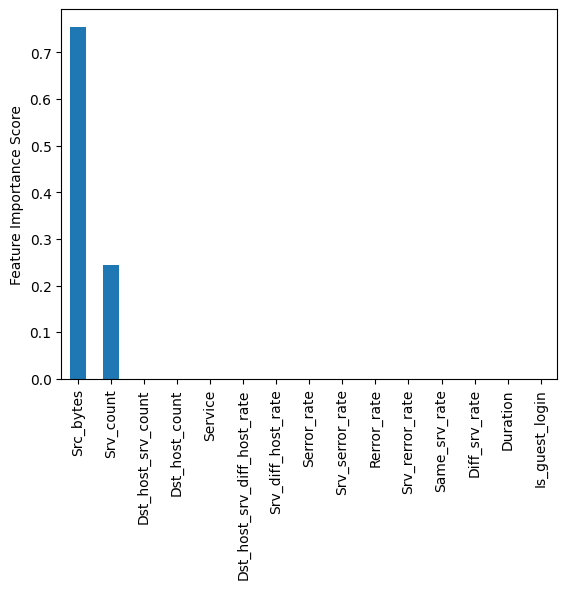

In [18]:
# In[4]:
# Gradient Boosting classifier between true and generated adversarial samples
# ROC curve should be around 50%
# last column is "name_of_the_attack" for the true attacks
# last column is "generated" for adversarial samples
def highlightFeatures(feat_imp, desc_lbl, indx=10):
    """ Highlight the most important features used by the classifier.
    feat_imp: features importance of the classifier, (N_Features-1)x1 array
    desc_lbl: description of the features, (N_Features-1)x1 dictionary
    indx: number of features to display
    """
    top10 = feat_imp[:indx]
    for n in range(len(top10)):
        name_ = top10.index[n]
        print(name_, "(", np.round(top10[n],4),")\n->", desc_lbl[name_], "\n")
#
# Last card of function highlightFeatures.
#
def modelFit(alg, X_train, y, performCV=False, printFeatureImportance=True, cv_folds=5):
    """ Fit a graddient boosting classifier and plot the most important 
    features in decreasing order.
    alg: GradientBoostingClassifier
    X_train: matrix containing the values of the features, N_SamplesxN_Features array
    y: Class-> Attack(1) vs. Normal(0), N_Samplesx1 array
    performCV: perform cross-validation, boolean
    printFeatureImportance: plot the features importance, boolean
    cv_fold: verbose setting, integer
    """
    #Fit the algorithm on the data
    alg.fit(X_train, y)
        
    # training set predictions
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    # cross-validation:
    if performCV:
        cv_score = cross_validate(alg, X_train, y, cv=cv_folds, scoring='roc_auc')
        #cv_score = cross_validation.cross_val_score(alg, X_train, y, cv=cv_folds, scoring='roc_auc')
    
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
              % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    # Feature Importance Plot
    if printFeatureImportance:
        top = 15
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        #feat_imp.plot(figsize=(12,8), kind='bar', title='Feature Importances')
        feat_imp[:top].plot(kind='bar')
        plt.ylabel('Feature Importance Score')
        plt.savefig('tmp_.pdf', bbox_inches='tight')
    return feat_imp
#
# Last card of function modelFit.
#
        
#Choose all predictors except target & IDcols
classifier = gboost(random_state=10, loss='deviance', learning_rate=0.05, n_estimators=200,
                     criterion='friedman_mse', max_depth=3)
feat_imp = modelFit(classifier, X_train, y_train)

# describe the top 10 features importance
highlightFeatures(feat_imp, desc_lbl)



Src_bytes ( 0.7548 )
-> Number of data bytes transferred from source to destination in single connection 

Srv_count ( 0.2452 )
-> Number of connections to the same service (port number) as the current connection in the past two seconds 

Dst_host_srv_count ( 0.0 )
-> Number of connections having the same port number 

Dst_host_count ( 0.0 )
-> Number of connections having the same destination host IP address 

Service ( 0.0 )
-> Destination network service used 

Dst_host_srv_diff_host_rate ( 0.0 )
-> The percentage of connections that were to different destination machines, among the connections aggregated in dst_host_srv_count 

Srv_diff_host_rate ( 0.0 )
-> The percentage of connections that were to different destination machines among the connections aggregated in srv_count 

Serror_rate ( 0.0 )
-> The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in count 

Srv_serror_rate ( 0.0 )
-> The percentage of connections tha

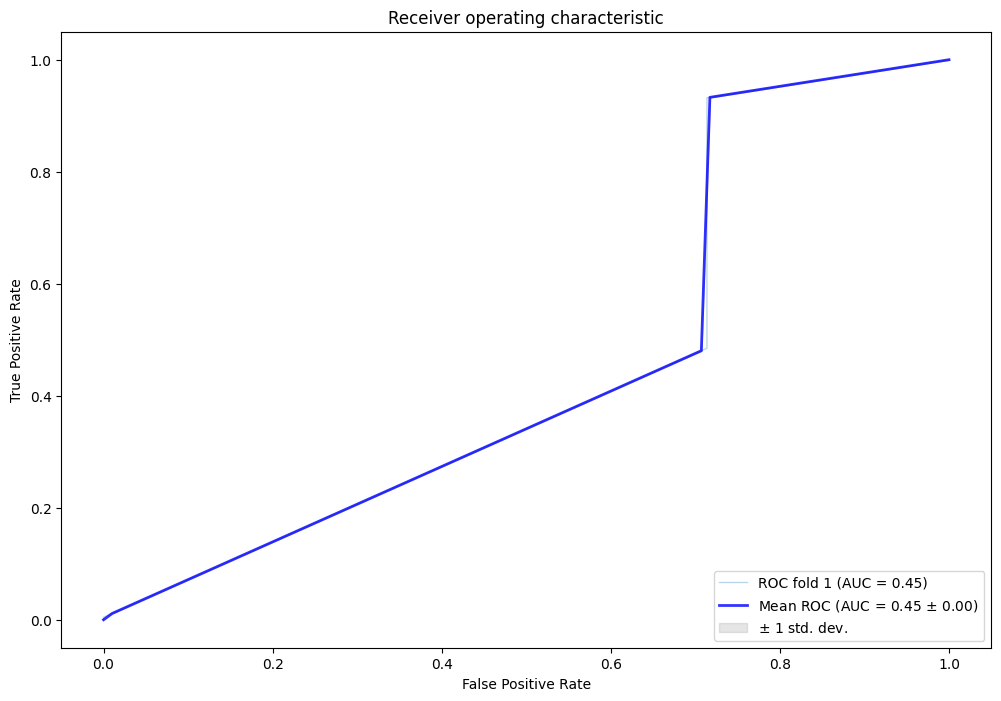

In [19]:
# In[4]:
# MLP Classifier between the true and the generated adversarial samples
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.995):
    """ Removing features with low variance
    """
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# training of the MLP classifier
classifier = MLPClassifier(hidden_layer_sizes=(100,), activation="tanh", 
                      solver="adam", alpha=0.0001, learning_rate="constant", 
                      learning_rate_init=0.001, 
                      max_iter=1000, shuffle=True, verbose=False)

#classifier = gboost(random_state=10, loss='deviance', learning_rate=0.05, 
#                    n_estimators=200, criterion='friedman_mse', max_depth=3)

# build the variance list thresholds
variance_df_agg = np.unique(np.var(df_aggregated.iloc[:,:-1]))
m = 0
for n in variance_df_agg[:-1]:
    if m == 0:
        curr_df = df_aggregated
        m = 1
        var_thres = None
    else:    
        curr_df = variance_threshold_selector(df_aggregated, n)
        var_thres = np.round(n, 4)
    
    # separate the data set into train and test data sets
    y = curr_df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(curr_df.iloc[:,:-1], \
                                                        y, test_size=.2, random_state=42)
    y_score = classifier.fit(X_train, y_train)
    #feat_imp = modelFit(classifier, X_train, y_train)
    # describe the top 10 features importance
    highlightFeatures(feat_imp, desc_lbl)
    
    fpr, tpr, threshold = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print("Variance Threshold:", var_thres)
    print(curr_df.columns[:-1]) # we do not select the target column
    print("auc:", roc_auc, "\n")


# ### CODE HERE ### 
# In[6]:
# Display the ROC curve of the classifier
y_score = classifier.fit(X_train, y_train)
fpr2, tpr2, threshold = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

# Compute ROC curve and ROC area for each class
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
#probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

plt.figure(1, figsize=(12,8))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (1, roc_auc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
str1 = "GP" + str(GRADIENT_PENALTY_WEIGHT) + "_"
str2 = "MAXSIM" + str(MAX_SIM) + "_"
str3 = "NUMSAMPLES" + str(NUM_SAMPLES) + ".pdf"
plt.savefig('' + str1 + str2 + str3)
#plt.show()

# In[2]:
#fl = "./Data/IRT/MachineLearningCVE/"
#df = pd.read_csv(fl + 'Monday-WorkingHours.pcap_ISCX.csv', sep=",", header=0, low_memory=False)
#print(df)
#
#tags = list(df.columns.values)
#print(tags)

In [ ]:
# training set predictions
accuracy = classifier.score(X_test, y_test)
print('Test set accuracy: %.2f' % accuracy)


# Predict probabilities for the test data.
y_probs = classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Compute AUC
auc_value = auc(fpr, tpr)
print('AUC: %.2f' % auc_value)

classifierGboost = gboost(random_state=10, loss='deviance', learning_rate=0.05, n_estimators=200,
                     criterion='friedman_mse', max_depth=3)
y_score = classifierGboost.fit(X_train, y_train)

# training set predictions
accuracy = classifierGboost.score(X_test, y_test)
print('Test set accuracy: %.2f' % accuracy)


# Predict probabilities for the test data.
y_probs = classifierGboost.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Compute AUC
auc_value = auc(fpr, tpr)
print('AUC: %.2f' % auc_value)


Test set accuracy: 0.51
AUC: 0.51
Test set accuracy: 0.53
AUC: 0.53


Src_bytes ( 0.7548 )
-> Number of data bytes transferred from source to destination in single connection 

Srv_count ( 0.2452 )
-> Number of connections to the same service (port number) as the current connection in the past two seconds 

Dst_host_srv_count ( 0.0 )
-> Number of connections having the same port number 

Dst_host_count ( 0.0 )
-> Number of connections having the same destination host IP address 

Service ( 0.0 )
-> Destination network service used 

Dst_host_srv_diff_host_rate ( 0.0 )
-> The percentage of connections that were to different destination machines, among the connections aggregated in dst_host_srv_count 

Srv_diff_host_rate ( 0.0 )
-> The percentage of connections that were to different destination machines among the connections aggregated in srv_count 

Serror_rate ( 0.0 )
-> The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in count 

Srv_serror_rate ( 0.0 )
-> The percentage of connections tha

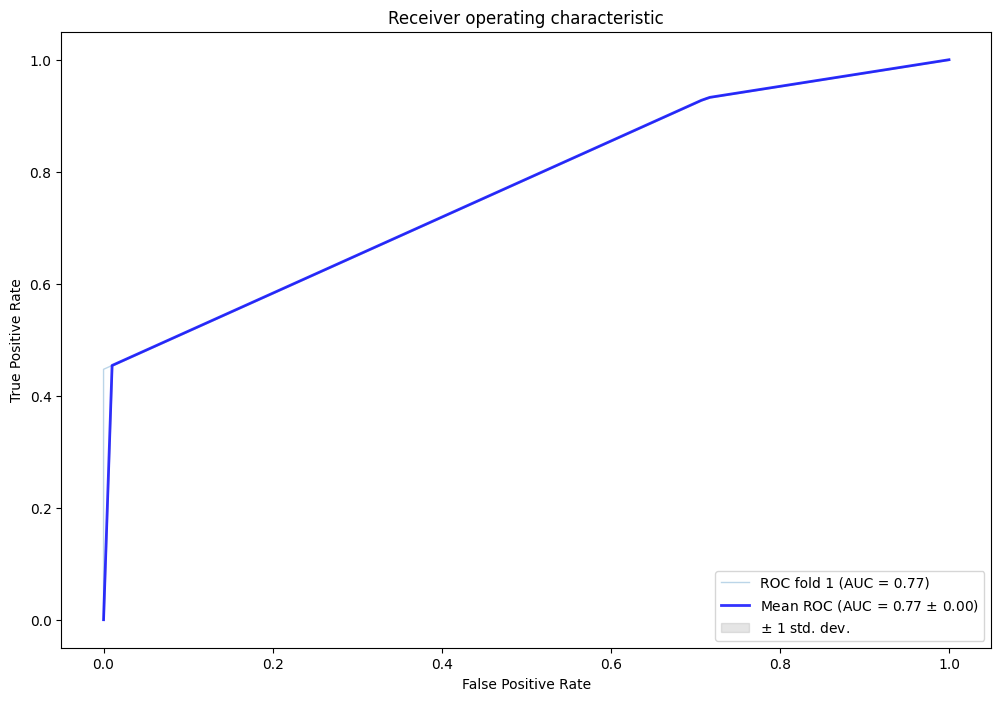

In [20]:
def variance_threshold_selector(data, threshold=0.995):
    """ Removing features with low variance
    """
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# training of the MLP classifier
classifier = gboost(random_state=10, loss='deviance', learning_rate=0.05, n_estimators=200,
                     criterion='friedman_mse', max_depth=3)

#classifier = gboost(random_state=10, loss='deviance', learning_rate=0.05, 
#                    n_estimators=200, criterion='friedman_mse', max_depth=3)

# build the variance list thresholds
variance_df_agg = np.unique(np.var(df_aggregated.iloc[:,:-1]))
m = 0
for n in variance_df_agg[:-1]:
    if m == 0:
        curr_df = df_aggregated
        m = 1
        var_thres = None
    else:    
        curr_df = variance_threshold_selector(df_aggregated, n)
        var_thres = np.round(n, 4)
    
    # separate the data set into train and test data sets
    y = curr_df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(curr_df.iloc[:,:-1], \
                                                        y, test_size=.2, random_state=42)
    y_score = classifier.fit(X_train, y_train)
    #feat_imp = modelFit(classifier, X_train, y_train)
    # describe the top 10 features importance
    highlightFeatures(feat_imp, desc_lbl)
    
    fpr, tpr, threshold = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print("Variance Threshold:", var_thres)
    print(curr_df.columns[:-1]) # we do not select the target column
    print("auc:", roc_auc, "\n")


# ### CODE HERE ### 
# In[6]:
# Display the ROC curve of the classifier
y_score = classifier.fit(X_train, y_train)
fpr2, tpr2, threshold = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])

# Compute ROC curve and ROC area for each class
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
#probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

plt.figure(1, figsize=(12,8))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (1, roc_auc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
str1 = "GP" + str(GRADIENT_PENALTY_WEIGHT) + "_"
str2 = "MAXSIM" + str(MAX_SIM) + "_"
str3 = "NUMSAMPLES" + str(NUM_SAMPLES) + ".pdf"
plt.savefig('' + str1 + str2 + str3)